In [1]:
import json
from pathlib import Path
import random
import pprint

import matplotlib
import matplotlib.pyplot as plt

import os

import torch

from config import load_config
from data import build_datasets, build_loader, build_detailed_test_dataloaders
from data import CollatorForMaskedSelectedTokens, CollatorForMaskedRandomSelectedTokens, IdentityCollator
from data import ALL_POSSIBLE_COLORS
from model import MultimodalModel, MultimodalPretrainingModel
from lightning import Trainer, seed_everything
from tqdm.auto import tqdm, trange

from PIL import Image

from torch.utils.data import DataLoader, Subset
from torch.nn.functional import softmax


pp = pprint.PrettyPrinter(indent=2)

2024-06-15 20:20:49.465611: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-8.0/lib64/
2024-06-15 20:20:49.465651: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def scene_tensor_to_txt(tensor):
    return ' '.join([processor.inv_vocabulary[t] for t in tensor.tolist()])

def print_scene_tensor(tensor):
    scene_text = scene_tensor_to_txt(tensor)
    print(scene_text.replace('[PAD]', '').replace('[SEP]','\n     '))
    
def print_parallel(tensor0, tensor1, tensor2, confidences, titles):
    ttl0, ttl1, ttl2 = titles
    print(f'{ttl0:6.6s} {ttl1:6.6s} {ttl2:6.6s}')
    for t0, t1, t2, conf in zip(
            tensor0.tolist(), tensor1.tolist(), tensor2.tolist(), confidences.tolist()):
        w0 = processor.inv_vocabulary[t0]
        w1 = processor.inv_vocabulary[t1]
        w2 = processor.inv_vocabulary[t2]
        
        if w0 == '[SEP]':
            print()
            continue
        if w0 == '[PAD]':
            break
        
        print_txt = f'{w0:6.6s} {w1:6.6s} {w2:6.6s} ({conf:.4f})'
        if w0 != w2:
            print_txt = bold(print_txt)
            

        print(print_txt)
        
def bold(text):
    return ("\033[1m" + text + "\033[0m")

In [36]:
# exp_name = 'multimodal-pretraining-v3--mlm_probability=0.15' 
# exp_name = 'multimodal-pretraining-v3--n_colors=139b--mlm_probability=0.15'
# exp_name = 'multimodal-pretraining-v3--n_colors=216b--mlm_probability=0.15'
# exp_name = 'multimodal-pretraining-v3--n_colors=139b_to_8_by_random--mlm_probability=0.15'
exp_name = 'multimodal-pretraining-v3--n_colors=216b_to_8_by_random--mlm_probability=0.15'

title_exp_name = {
    'multimodal-pretraining-v3--mlm_probability=0.15' : '8 Colors (Base)',
    'multimodal-pretraining-v3--n_colors=139--mlm_probability=0.15' : '139 Colors Dataset A',
    'multimodal-pretraining-v3--n_colors=139b--mlm_probability=0.15' : '139 Colors Dataset B',
    'multimodal-pretraining-v3--n_colors=216b--mlm_probability=0.15' : '216 Colors Dataset B',
    'multimodal-pretraining-v3--vit--mlm_probability=0.15' : '8 Colors Vit Encoder',
    'multimodal-pretraining-v3--n_colors=139b_to_8_by_random--mlm_probability=0.15': '139 Colors with Label Pooling',
    'multimodal-pretraining-v3--n_colors=216b_to_8_by_random--mlm_probability=0.15': '216 Colors with Label Pooling',
}[exp_name]

resume_from_path = f'outputs/{exp_name}/last.ckpt'
# resume_from_path = f'outputs/{exp_name}/last-v1.ckpt'

checkpoint = torch.load(resume_from_path)

print('Epoch:', checkpoint['epoch'])

Epoch: 999


In [37]:
!ls outputs/$exp_name

'epoch=109-step=16170.ckpt'  'epoch=579-step=85260.ckpt'
'epoch=119-step=17640.ckpt'  'epoch=589-step=86730.ckpt'
'epoch=129-step=19110.ckpt'  'epoch=599-step=88200.ckpt'
'epoch=139-step=20580.ckpt'  'epoch=59-step=8820.ckpt'
'epoch=149-step=22050.ckpt'  'epoch=609-step=89670.ckpt'
'epoch=159-step=23520.ckpt'  'epoch=619-step=91140.ckpt'
'epoch=169-step=24990.ckpt'  'epoch=629-step=92610.ckpt'
'epoch=179-step=26460.ckpt'  'epoch=639-step=94080.ckpt'
'epoch=189-step=27930.ckpt'  'epoch=649-step=95550.ckpt'
'epoch=199-step=29400.ckpt'  'epoch=659-step=97020.ckpt'
'epoch=19-step=2940.ckpt'    'epoch=669-step=98490.ckpt'
'epoch=209-step=30870.ckpt'  'epoch=679-step=99960.ckpt'
'epoch=219-step=32340.ckpt'  'epoch=689-step=101430.ckpt'
'epoch=229-step=33810.ckpt'  'epoch=699-step=102900.ckpt'
'epoch=239-step=35280.ckpt'  'epoch=69-step=10290.ckpt'
'epoch=249-step=36750.ckpt'  'epoch=709-step=104370.ckpt'
'epoch=259-step=38220.ckpt'  'epoch=719-step=105840.ckpt'
'epoch=269-step=39690.ckpt'  '

In [38]:
config = load_config(exp_name)

config.vocabulary_path = config.vocabulary_path.replace('/workspace/' ,'/workspace1/')
config.base_path = config.base_path.replace('/workspace/' ,'/workspace1/')

Loading multimodal-pretraining-v3--n_colors=216b_to_8_by_random--mlm_probability=0.15 last checkpoint config from outputs/multimodal-pretraining-v3--n_colors=216b_to_8_by_random--mlm_probability=0.15/last.ckpt


In [39]:
pp.pprint(vars(config))

{ 'adapt_embedding_from': 0,
  'aug_zero': 0,
  'aug_zero_independent': False,
  'base_path': '/workspace1/fidelrio/CLEVR_CoGenT_v1.0/colored/216b',
  'batch_size': 256,
  'comet_experiment_key': 'baded06c6dcd4fb99984748e7d0d2787',
  'd_hidden': 256,
  'display_object_properties': False,
  'filter_symmetric_relations': True,
  'freeze_vit_embedding': False,
  'image_pretraining': False,
  'lr': 0.0001,
  'max_epochs': 1000,
  'max_question_size': 45,
  'max_scene_size': 60,
  'mlm_probability': 0.15,
  'mp_probability': 0.75,
  'multimodal_pretraining': True,
  'multimodal_training': False,
  'n_head': 4,
  'n_layers': 4,
  'n_outputs': 28,
  'n_patches': 196,
  'n_tokens': 96,
  'not_normalize_image': False,
  'only_front_right_relations': False,
  'optimizer': 'adam',
  'pad_idx': 1,
  'patch_height': 16,
  'patch_width': 16,
  'profile': False,
  'rels_to_sample': 0,
  'resume_training': True,
  'seed': 42,
  'shuffle_object_identities': True,
  'start_from': '',
  'token_translatio

In [40]:
train_dataset, test_dataset, systematic_dataset = build_datasets(config)
config.pad_idx = train_dataset.pad_idx

Adapting vocab from 304 to 96


In [41]:
test_loaders = build_detailed_test_dataloaders(test_dataset, config) # type_of_tokens_to_test
systematic_loaders = build_detailed_test_dataloaders(systematic_dataset, config) # type_of_tokens_to_test

In [42]:
model = MultimodalModel(config)
training_model = MultimodalPretrainingModel(model, config)
training_model.load_state_dict(checkpoint['state_dict'])

/home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/lightning/pytorch/utilities/parsing.py:270: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


<All keys matched successfully>

In [43]:
processor = test_dataset.processor

In [44]:
relation_tokens = sorted([processor.vocabulary[w] for w in ['left', 'right', 'behind', 'front']])
color_tokens = sorted(
    [processor.vocabulary[w] for w in ALL_POSSIBLE_COLORS if w in processor.vocabulary])
shapes_tokens = sorted([processor.vocabulary[w] for w in ['cylinder', 'sphere', 'cube']])
materials_tokens = sorted([processor.vocabulary[w] for w in ['metal', 'rubber']])
size_tokens = sorted([processor.vocabulary[w] for w in ['small', 'large']])

In [45]:
# collator = CollatorForMaskedLanguageModeling(config, processor)
collator = CollatorForMaskedSelectedTokens(config, processor, tokens=color_tokens)
# collator = CollatorForMaskedRandomSelectedTokens(config, processor, tokens=shapes_tokens, p=0.2)
# collator = IdentityCollator(config, processor)

In [46]:
# sample_idx = 333
sample_idx = random.randint(0, len(test_dataset))
image, scene = test_dataset.retrieve_raw(sample_idx)
image_tensor, scene_tensor = test_dataset[sample_idx]

collated_images, collated_scenes, collated_labels = collator([(image_tensor, scene_tensor)])

print(sample_idx)

8643


[CLS] [O2] small #2db259 metal sphere 
      [O0] small #862db2 metal sphere 
      [O3] small #b200b2 rubber cylinder 
      [O1] large #00b2b2 metal cube                                    

[CLS] [O2] small [MASK] metal sphere 
      [O0] small [MASK] metal sphere 
      [O3] small [MASK] rubber cylinder 
      [O1] large [MASK] metal cube                                    


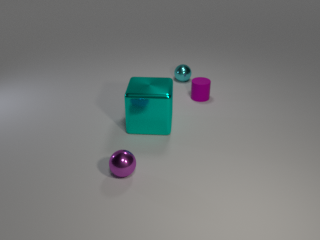

In [47]:
print_scene_tensor(scene_tensor)
print()
print_scene_tensor(collated_scenes[0])

image

In [48]:
output_logits = model(collated_images, collated_scenes)

confidences = softmax(output_logits, dim=-1).max(dim=-1).values
predictions = output_logits.argmax(dim=-1)

In [49]:
print_parallel(
    scene_tensor,
    collated_scenes[0],
    predictions[0][-config.max_scene_size:],
    confidences[0][-config.max_scene_size:],
    titles=['gd_tth', 'input', 'output']
)

gd_tth input  output
[CLS]  [CLS]  sphere (0.7335)
[O2]   [O2]   #00b2b (0.5880)
small  small  small  (1.0000)
#2db25 [MASK] #2db25 (0.6976)
metal  metal  metal  (0.9993)
sphere sphere sphere (0.9988)

[O0]   [O0]   cylind (0.3510)
small  small  small  (1.0000)
#862db [MASK] #2db25 (0.5291)
metal  metal  metal  (0.9999)
sphere sphere sphere (0.9998)

[O3]   [O3]   #2db25 (0.3640)
small  small  small  (1.0000)
#b200b [MASK] #b200b (0.9995)
rubber rubber rubber (0.9991)
cylind cylind cylind (0.9999)

[O1]   [O1]   cube   (0.9360)
large  large  large  (1.0000)
#00b2b [MASK] #00b2b (0.9857)
metal  metal  metal  (1.0000)
cube   cube   cube   (1.0000)


In [50]:
trainer = Trainer(max_epochs=config.max_epochs,
                  accelerator="gpu",
                  devices=torch.cuda.device_count()
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [51]:
vocab = processor.vocabulary

relation_tokens = sorted(
    [vocab[w] for w in ['left', 'right', 'behind', 'front'] if w in vocab])
color_tokens = sorted(
    [vocab[w] for w in ALL_POSSIBLE_COLORS if w in vocab])
#     [vocab[w] for w in ['blue', 'brown', 'cyan', 'green', 'red', 'purple', 'yellow', 'gray']])
shapes_tokens = sorted(
    [vocab[w] for w in ['cylinder', 'sphere', 'cube'] if w in vocab])
materials_tokens = sorted(
    [vocab[w] for w in ['metal', 'rubber'] if w in vocab])
size_tokens = sorted(
    [vocab[w] for w in ['small', 'large'] if w in vocab])

random_baseline = {
    'relation':  1 / len(relation_tokens),
    'color':  1 / len(color_tokens),
    'shapes':  1 / len(shapes_tokens),
    'materials':  1 / len(materials_tokens),
    'size':  1 / len(size_tokens),
    'identity':  1 / len(processor.vocabulary),
}

In [52]:
batch_size = 256
test_indices = random.sample(range(len(test_dataset)), k=batch_size)
pc_subset_test = Subset(test_dataset, test_indices)
pc_subset_systematic = Subset(systematic_dataset, test_indices)

color_collator = CollatorForMaskedSelectedTokens(config, processor, tokens=color_tokens)
shapes_collator = CollatorForMaskedSelectedTokens(config, processor, tokens=shapes_tokens)
dlkwargs = {
    'batch_size': batch_size,
    'num_workers': int(os.environ.get("SLURM_CPUS_PER_TASK", 4)),
    'pin_memory': torch.cuda.is_available(),
}

test_loaders['color'] = DataLoader(pc_subset_test, shuffle=False, collate_fn=color_collator, **dlkwargs)
systematic_loaders['color'] = DataLoader(pc_subset_systematic, shuffle=False, collate_fn=color_collator, **dlkwargs)
test_loaders['shapes'] = DataLoader(pc_subset_test, shuffle=False, collate_fn=shapes_collator, **dlkwargs)
systematic_loaders['shapes'] = DataLoader(pc_subset_systematic, shuffle=False, collate_fn=shapes_collator, **dlkwargs)

In [53]:
mask_token_idx = processor.vocabulary['[MASK]']

In [54]:
device = torch.device('cuda')

In [55]:
model = model.to(device)

In [56]:
feature_maps = []  # This will be a list of Tensors, each representing a feature map

def hook_feat_map(mod, inp, out):
    feature_maps.clear()
    feature_maps.append(out)

model.transformer.register_forward_hook(hook_feat_map)

feats_by_task = {}

In [57]:
# loaders = test_loaders
loaders = systematic_loaders

gt = []

In [58]:
task = 'color'

images, scenes, labels = next(iter(loaders[task]))
images, scenes, labels = images.to(device), scenes.to(device), labels.to(device)
cimages, cscenes, clabels = images, scenes, labels
with torch.no_grad():
    output_logits = model(images, scenes)

    features = feature_maps[0]
    confidences = softmax(output_logits, dim=-1).max(dim=-1).values
    predictions = output_logits.argmax(dim=-1)

    scene_features = features.transpose(1,0)[:,-config.max_scene_size:]
    mask_idxs = (scenes == mask_token_idx)
    gt.append(labels[:,-config.max_scene_size:][mask_idxs])
    feats_by_task[task] = scene_features[mask_idxs].cpu()

In [59]:
task = 'shapes'

images, scenes, labels = next(iter(loaders[task]))
images, scenes, labels = images.to(device), scenes.to(device), labels.to(device)
cimages, cscenes, clabels = images, scenes, labels
with torch.no_grad():
    output_logits = model(images, scenes)

    features = feature_maps[0]
    confidences = softmax(output_logits, dim=-1).max(dim=-1).values
    predictions = output_logits.argmax(dim=-1)

    scene_features = features.transpose(1,0)[:,-config.max_scene_size:]
    mask_idxs = (scenes == mask_token_idx)
    gt.append(labels[:,-config.max_scene_size:][mask_idxs])
    feats_by_task[task] = scene_features[mask_idxs].cpu()

In [60]:
feats_by_task['color'].shape, feats_by_task['shapes'].shape

(torch.Size([1623, 256]), torch.Size([1623, 256]))

In [61]:
c = torch.cat(gt).cpu().numpy()

In [62]:
X = torch.cat([feats_by_task['color'], feats_by_task['shapes']]).numpy()
# X = feats_by_task['shapes'].numpy()

In [63]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

In [64]:
X_2d_color = X_2d[:len(feats_by_task['color']),:]
c_color = c[:len(feats_by_task['color'])]
X_2d_shapes = X_2d[len(feats_by_task['shapes']):,:]
c_shapes = c[len(feats_by_task['shapes']):]

In [65]:
c_color, c_shapes

(array([95, 88, 89, ..., 88, 94, 94]), array([34, 34, 34, ..., 34, 76, 76]))

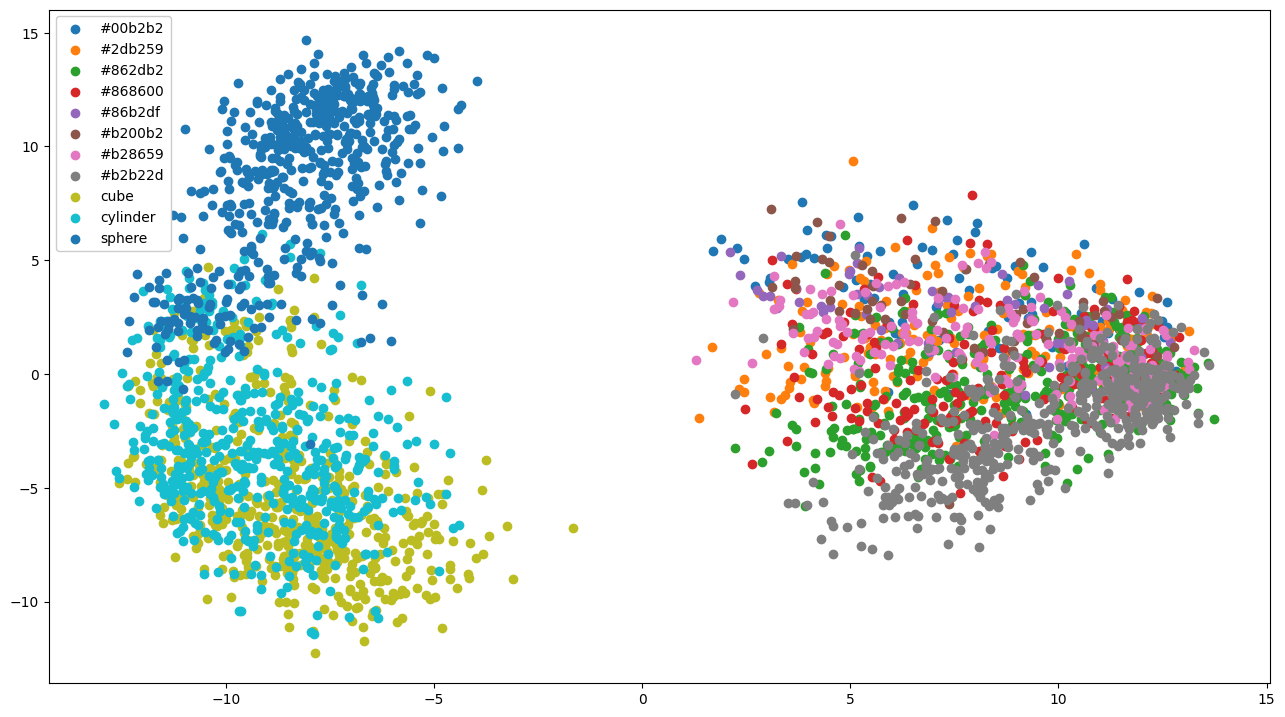

In [66]:
plt.figure(figsize=(9*1.75,5*1.75))

# scatter_color = plt.scatter(X_2d_color[:,0], X_2d_color[:,1], c=c_color, label='color')
# scatter_shapes = plt.scatter(X_2d_shapes[idxs], X_2d_shapes[idxs], c=c_shapes[idxs], label='shapes', )
for c in set(c_color):
    idxs = c_color == c 
    color = processor.inv_vocabulary[c]
    if len(set(c_color)) > 8:
        scatter_shapes = plt.scatter(X_2d_color[:,0][idxs], X_2d_color[:,1][idxs])
    else:
        scatter_shapes = plt.scatter(X_2d_color[:,0][idxs], X_2d_color[:,1][idxs], label=color)
for c in set(c_shapes):
    idxs = c_shapes == c 
    shape = processor.inv_vocabulary[c]
    scatter_shapes = plt.scatter(X_2d_shapes[:,0][idxs], X_2d_shapes[:,1][idxs], label=shape)
    
# plt.xlabel('Attribute scatterType')
# plt.ylabel('Accuracy')
# plt.ylim(0., 1.05)
# plt.title('Bar Chart with Two Columns Per Category')
# plt.xticks(range(len(categories)), category_labels)
plt.legend(framealpha=1, loc='upper left')

# Show plot
# plt.savefig('exports/base-attributes.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()